# Credit VAR of a Swap

The goal of the project is to compute the Credit VAR (99.9th percentile) of a swap in which the counterparty might default. The input parameters are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotation);
* a set of forward libor rates and their fixing dates;
* the static data of the swap (nominal, start date, maturity, underlying libor tenor, etc..). The fixed rate of the swap is such that if there was no counterparty risk, the product would be traded at par. You are requested to compute it;
* a set of survival probabilities for the risky counterparty;
* the recovery rate for this swap (i.e. the fraction of the market value that it is expected to recover in case of default);
* the volatility of the swap rate, which is assumed to be constant through time (the swap rate is lognormal with fixed volatility).

The swap starts today and the horizon for the VAR calculation is before any future payments. 

## Notes and Hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for credit risk evaluation.

Please try to reuse as much as possible the code in $\texttt{finmarkets.py}$, and only when it is not viable write your own classes.


In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [3]:
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import ForwardRateCurve

pricing_date = date.today()

surv_prob = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/survival_probabilities_proj3.csv")
ois_quotes = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/ois_quotes.xlsx")
df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx", sheet_name="EURIBOR6M")
dates = [pricing_date + relativedelta(months=i) for i in df['months']]
libor_curve = ForwardRateCurve(dates, df['rates']*0.01)

irs_to_price = {
    'nominal': 100e6, 
    'libor_tenor_months': 6,
    'fixed_leg_frequency': 6,
    'maturity_months': 72
}

credit_var_date = date.today() + relativedelta(years=2)
recovery = 0.4
volatility = 0.4
mc_runs = 10000
percentile = 0.999

In [5]:
from finmarkets import OvernightIndexSwap

pillar_dates = [pricing_date]
swaps = []
for q in range(len(ois_quotes)):
  swap = OvernightIndexSwap(100e6, pricing_date, 
                            ois_quotes.loc[q, 'quotes']*0.01,
                            ois_quotes.loc[q, 'months'])
    
  swaps.append(swap)
  pillar_dates.append(swap.payment_dates[-1])

In [6]:
import numpy as np
from finmarkets import DiscountCurve

def objective_function(x):
  x = np.insert(x, 0, 1)
  curve = DiscountCurve(pillar_dates, x)
    
  sum_sq = 0.0
  for swap in swaps:
    sum_sq += swap.npv(curve) ** 2
        
  return sum_sq

In [7]:
from scipy.optimize import minimize

x0 = [0.5 for i in range(len(swaps))]
bounds = [(0.01, 100.0) for i in range(len(swaps))]

result = minimize(objective_function, x0, bounds=bounds)

In [8]:
print (result)
print (objective_function(x0))
print (objective_function(result.x))

      fun: 6.029979351526169
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1929.00430019,  17521.24514629,  21224.77406872,  14049.87395707,
         -197.24866299, -13961.94176834, -22941.76926655, -24870.49955606,
       -21257.51050611, -15188.5685195 , -10403.49789023,  19947.18637382,
        34754.72772781,    278.54913969,  -2662.19184638,  -1895.5453889 ,
          327.52281478,   5646.32982845,  10642.80110271,  16244.81944997,
        21776.86258174,  27480.67200112,  31461.7996085 , -10170.43566099,
        10635.59269794, -30534.32695448, -71128.12467769,  59337.26787424,
       -14316.67453165,  -6576.94873265])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 465
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([0.99941222, 0.99825489, 0.99686143, 0.99525677, 0.99335846,
       0.99136706, 0.9892002 , 0.98696958, 0.98469213, 0.98233439,
       0.98001276, 0.97763574, 0.9638143 , 0.95044587, 0.

In [15]:
dfs = np.insert(result.x, 0, 1)
discount_curve = DiscountCurve(pillar_dates, dfs)

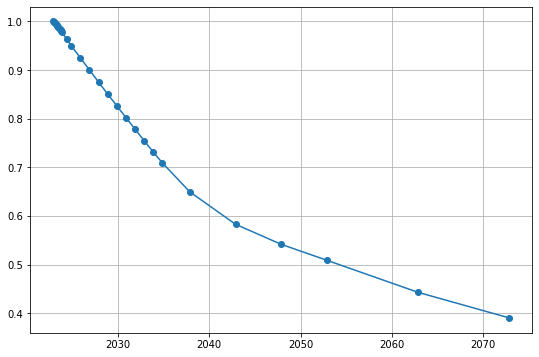

In [16]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(pillar_dates, dfs, marker='o')
plt.grid(True)
plt.show()

In [17]:
from finmarkets import InterestRateSwap

dummy_fixed_rate = 1
irs_random = InterestRateSwap(irs_to_price['nominal'], 
                              credit_var_date, 
                              dummy_fixed_rate, 
                              irs_to_price['libor_tenor_months'],
                              irs_to_price['maturity_months']) 
                                                        
swap_rate = irs_random.swap_rate(discount_curve, libor_curve)
print (swap_rate)

0.027477119742792492


In [18]:
irs = InterestRateSwap(irs_to_price['nominal'], credit_var_date, 
                       swap_rate, 
                       irs_to_price['libor_tenor_months'],
                       irs_to_price['maturity_months']) 
print (irs.npv(discount_curve, libor_curve))

0.0


In [19]:
from finmarkets import CreditCurve
from datetime import date

pillar_dates = [pricing_date]
ndps = [1.0]

dates = [pricing_date + relativedelta(years=i) for i in surv_prob['years']]
credit_curve = CreditCurve(dates, surv_prob['ndp'])
print (credit_curve.ndp(date.today() + relativedelta(years=20)))

0.539


In [21]:
import numpy as np
import math

n_scenarios = 1000000
payoffs = []
npv_mc_list = []

maturity = max(irs.fixed_leg_dates[-1], irs.floating_leg_dates[-1])
S = swap_rate
T = (credit_var_date - pricing_date).days/365
A = irs.annuity(discount_curve)

for i_scenario in range(n_scenarios):
  np.random.seed(i_scenario)
    
  if np.random.uniform(0, 1) > credit_curve.ndp(credit_var_date):
      default = True
  else:
      default = False
    
  # simulates the swap rate in this scenario
  S_simulated = S * math.exp(-0.5 * volatility * volatility * T + 
                              volatility * math.sqrt(T) * np.random.normal())
    
  # calculate the swap NPV in this scenario
  swap_npv = irs.notional * (S_simulated - irs.fixed_rate)*A  
    
  if default and swap_npv > 0:
      swap_npv *= (1 - recovery)
      # adds the payoff of the swap, in this scenario, to the list
      payoffs.append(swap_npv)

#print (payoffs)

Credit Var: 283204210.92 Eur


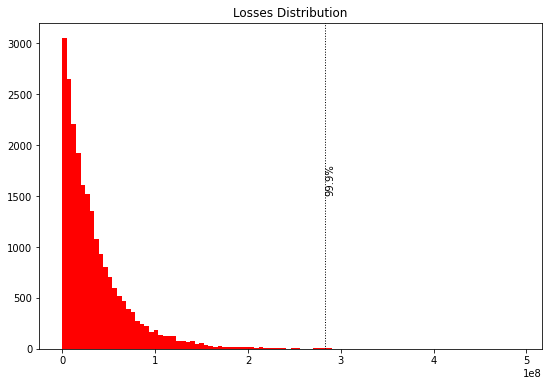

In [23]:
from matplotlib import pyplot as plt
#At the 95% of confidence interval

a = np.array(payoffs)
credit_var = np.percentile(a, percentile*100)

print('Credit Var: {:.2f} Eur'.format(credit_var))

plt.title("Losses Distribution")
y, x, _ = plt.hist(a, bins=100, facecolor='red')
plt.axvline(x = credit_var, ymin=0, ymax=90,linestyle=':',linewidth=1, color = 'k')
plt.text(credit_var, y.max()/2, r"{:.1f}%".format(percentile*100), fontsize=10, rotation=90, color='k')

plt.show()